In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import spotipy

from tools import *
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [4]:
# Loading the data
# I downloaded the data from the url given below and put it in my project directory in a folder called data

url = "https://raw.githubusercontent.com/vaslnk/Spotify-Song-Recommendation-ML/master/data/mpd.slice.0-999.json"
data = json.load(open('data/mpd.slice.0-999.json'))

# We want the playlists data
df = pd.DataFrame(data["playlists"])

In [5]:
# Checking the data we have
df.head(10)

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN
5,Wedding,false,5,1430956800,80,71,1,"[{'pos': 0, 'artist_name': 'Cali Swag District...",3,19156557,56,NaN
6,I Put A Spell On You,false,6,1477094400,16,15,1,"[{'pos': 0, 'artist_name': 'Creedence Clearwat...",2,3408479,13,NaN
7,2017,false,7,1509321600,53,52,1,"[{'pos': 0, 'artist_name': 'Fink', 'track_uri'...",38,12674796,48,NaN
8,BOP,false,8,1508976000,46,37,2,"[{'pos': 0, 'artist_name': 'Catfish and the Bo...",21,9948921,23,NaN
9,old country,false,9,1501804800,21,20,1,"[{'pos': 0, 'artist_name': 'Willie Nelson', 't...",10,4297488,18,NaN


In [6]:
df.describe()
# It seems there are outliers in num_tracks, num_albums, num_followers, num_artists
# I will check if they are for the same playlist

,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists
count,1000.000000,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,499.500000,1.476247e+09,67.50300,50.526000,2.583000,17.546000,1.574061e+07,38.746000
std,288.819436,3.719567e+07,55.00334,41.448997,32.813501,20.978751,1.290575e+07,31.245091
min,0.000000,1.322611e+09,5.00000,2.000000,1.000000,2.000000,1.002971e+06,3.000000
25%,249.750000,1.459944e+09,25.00000,19.000000,1.000000,4.000000,5.810390e+06,16.000000
50%,499.500000,1.491048e+09,50.00000,38.000000,1.000000,10.000000,1.163116e+07,30.000000
75%,749.250000,1.505779e+09,92.50000,70.000000,1.250000,22.000000,2.181915e+07,53.000000
max,999.000000,1.509494e+09,245.00000,225.000000,1038.000000,178.000000,5.781713e+07,175.000000


In [7]:
# It seems num_tracks, num_albums, num_artists outliers are for the same playlists
df[df['num_tracks'] == 245]

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
123,w o r k o u t,false,123,1500681600,245,225,1,"[{'pos': 0, 'artist_name': 'Trap Beckham', 'tr...",26,55676545,171,NaN
743,New ish,false,743,1509148800,245,168,1,"[{'pos': 0, 'artist_name': 'Big Sean', 'track_...",131,57648694,103,NaN


In [8]:
# Let's check the playlist with the highest followers to see if we have something insightful
best_playlist = df[df['num_followers'] == 1038]['name']
print(best_playlist)
df[df['num_followers'] == 1038]


765    Tangled
Name: name, dtype: object


,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
765,Tangled,false,765,1499040000,81,37,1038,"[{'pos': 0, 'artist_name': 'Mandy Moore', 'tra...",15,15112167,59,NaN


In [9]:
# Taking the tracks for each playlist and creating a separate dataframe for it
track_df = []
pl_counter = 0
for track in df['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df['name'][pl_counter])
        track_df.append(x)
    pl_counter += 1

track_df = pd.DataFrame(track_df, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Checking if our data frame is correct
track_df.head(10)



,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks
5,5,Usher,spotify:track:0XUfyU2QviPAs6bxSpXYG4,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Yeah!,spotify:album:0vO0b1AvY49CPQyVisJLj0,250373,Confessions,Throwbacks
6,6,Usher,spotify:track:68vgtRHr7iZHpzGpon6Jlo,spotify:artist:23zg3TcAtWQy7J6upgbUnj,My Boo,spotify:album:1RM6MGv6bcl6NrAG8PGoZk,223440,Confessions,Throwbacks
7,7,The Pussycat Dolls,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,Buttons,spotify:album:5x8e8UcCeOgrOzSnDGuPye,225560,PCD,Throwbacks
8,8,Destiny's Child,spotify:track:7H6ev70Weq6DdpZyyTmUXk,spotify:artist:1Y8cdNmUJH7yBTd9yOvr5i,Say My Name,spotify:album:283NWqNsCA9GwVHrJk59CG,271333,The Writing's On The Wall,Throwbacks
9,9,OutKast,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,spotify:artist:1G9G7WwrXka3Z1r7aIDjI7,Hey Ya! - Radio Mix / Club Mix,spotify:album:1UsmQ3bpJTyK6ygoOOjG1r,235213,Speakerboxxx/The Love Below,Throwbacks


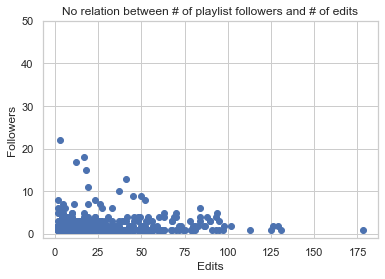

In [10]:
# Exploratory Data Analysis

plt.plot( df['num_edits'], df['num_followers'], 'o')

# Set limits to avoid the outlier
plt.ylim(-1,50)
plt.title("No relation between # of playlist followers and # of edits")
plt.xlabel("Edits")
plt.ylabel("Followers")
plt.show()

In [11]:
# Most playlists have 1-4 followers
df['num_followers'].value_counts()

1       750
2       138
3        57
4        24
5         8
6         6
7         4
8         3
9         2
18        1
10        1
11        1
13        1
1038      1
15        1
17        1
22        1
Name: num_followers, dtype: int64

Text(0.5, 0, 'Total songs across playlists')

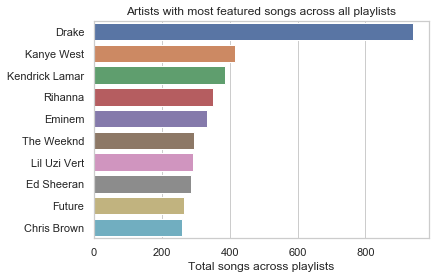

In [12]:
# Checking which artists are featured most across all playlists
values = list(track_df['artist_name'].value_counts())
names = track_df['artist_name'].value_counts().index.tolist()

ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

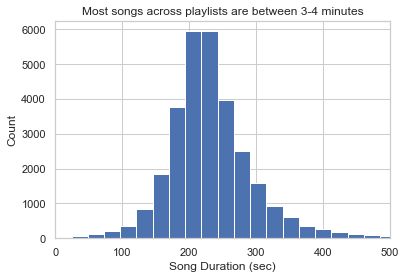

In [13]:
# Checking the distribution of song durations
track_df['duration_sec'] = track_df['duration_ms']/1000
plt.title("Most songs across playlists are between 3-4 minutes")
plt.xlabel("Song Duration (sec)")
plt.ylabel("Count")
plt.hist(track_df.drop_duplicates(['track_name'], keep='first')['duration_sec'], bins = 100)
plt.xlim(0,500)
plt.show()

In [14]:
# Getting the uri for each track
mah_tracks = track_df.track_uri.unique()
mah_tracks = list(mah_tracks)
mah_tracks_uri = []
for track in mah_tracks:
    uri = track.split("track:")
    mah_tracks_uri.append(uri[1])

In [15]:
# Getting data from Spotify api

client_credentials_manager = SpotifyClientCredentials('ca4bc09f475c428ea4a78ac1149aa78b', '72743d3e010d44d0b904b259695194d3', None)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [33]:
# Got track info on a thousand songs
track_info = []
counts = list(np.arange(0,1001,100))
for count in counts:
    for x in mah_tracks_uri[count:count+100]:
        song = sp.audio_features(tracks= x)[0]
        song["track"] = track_df.loc[track_df["track_uri"] == song["uri"]]["track_name"].iloc[0]
        track_info.append(song)

In [34]:
# We have a dataframe with info on each track
track_info_df = pd.DataFrame(track_info)
track_info_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,Lose Control (feat. Ciara & Fat Man Scoop)
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4,Toxic
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4,Crazy In Love
3,0.891,0.714,4,-6.055,0,0.1400,0.20200,0.000234,0.0521,0.818,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4,Rock Your Body
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4,It Wasn't Me
5,0.881,0.788,2,-4.669,1,0.1680,0.02120,0.000000,0.0377,0.592,104.997,audio_features,0XUfyU2QviPAs6bxSpXYG4,spotify:track:0XUfyU2QviPAs6bxSpXYG4,https://api.spotify.com/v1/tracks/0XUfyU2QviPA...,https://api.spotify.com/v1/audio-analysis/0XUf...,250373,4,Yeah!
6,0.662,0.507,5,-8.238,1,0.1180,0.25700,0.000000,0.0465,0.676,86.412,audio_features,68vgtRHr7iZHpzGpon6Jlo,spotify:track:68vgtRHr7iZHpzGpon6Jlo,https://api.spotify.com/v1/tracks/68vgtRHr7iZH...,https://api.spotify.com/v1/audio-analysis/68vg...,223440,4,My Boo
7,0.570,0.821,2,-4.380,1,0.2670,0.17800,0.000000,0.2890,0.408,210.857,audio_features,3BxWKCI06eQ5Od8TY2JBeA,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,https://api.spotify.com/v1/tracks/3BxWKCI06eQ5...,https://api.spotify.com/v1/audio-analysis/3BxW...,225560,4,Buttons
8,0.713,0.678,5,-3.525,0,0.1020,0.27300,0.000000,0.1490,0.734,138.009,audio_features,7H6ev70Weq6DdpZyyTmUXk,spotify:track:7H6ev70Weq6DdpZyyTmUXk,https://api.spotify.com/v1/tracks/7H6ev70Weq6D...,https://api.spotify.com/v1/audio-analysis/7H6e...,271333,4,Say My Name
9,0.728,0.974,4,-2.261,0,0.0665,0.10300,0.000532,0.1750,0.965,79.526,audio_features,2PpruBYCo4H7WOBJ7Q2EwM,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,https://api.spotify.com/v1/tracks/2PpruBYCo4H7...,https://api.spotify.com/v1/audio-analysis/2Ppr...,235213,4,Hey Ya! - Radio Mix / Club Mix


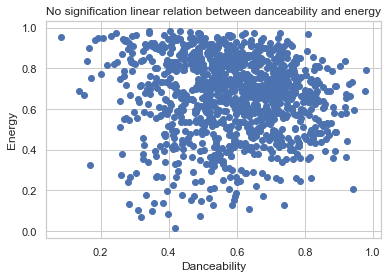

In [18]:
# Let's do some EDA on our tracks
plt.plot(track_info_df['danceability'], track_info_df['energy'], 'o')
plt.title("No signification linear relation between danceability and energy")
plt.ylabel("Energy")
plt.xlabel("Danceability")
plt.show()

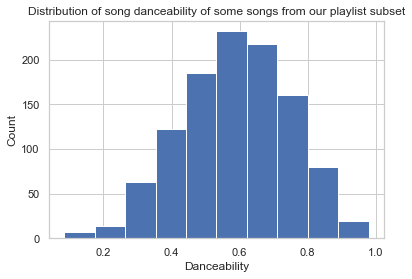

In [19]:
plt.hist(track_info_df['danceability'])
plt.title("Distribution of song danceability of some songs from our playlist subset")
plt.ylabel("Count")
plt.xlabel("Danceability")
plt.show()

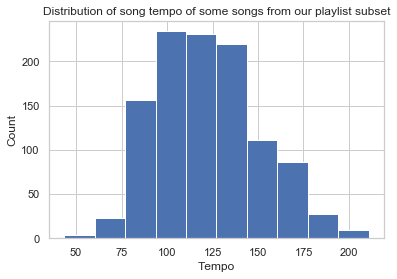

In [20]:
plt.hist(track_info_df['tempo'])
plt.title("Distribution of song tempo of some songs from our playlist subset")
plt.ylabel("Count")
plt.xlabel("Tempo")
plt.show()

**Decision on baseline Model based on data initial EDA:**

So we are taking info of tracks of songs that we got from our initial subset of playlists. Our assumption is that these playlists are representative of all playlists in Spotify.

Once we do some EDA, we realize that track info like "Danceability" and "Tempo" are pretty normally distributed can be used as good metrics for our baseline model. We would have looked at similar type of info like danceability and energy and create a baseline model of song recommendation that combines the two. However, we didn't find any relationship between those two metrics and thus it might not be a good idea to recommend songs using a combination of those two metrics.

So our baseline model: Use 'Danceability' of a song that user listens to recommend future songs. 

Since this is a simple model, we will break any ties based on Python's automatic list sorting (so, alphabetically within ties). 

In [74]:
# Here is our baseline model
def baseline(tracks, df, n_pred):
    '''
    Input:
    1. tracks = Takes a list of track titles as input (strings)
    2. df = Dataframe containing all track info
    Output:
    recs = Recommends 10 track uri based on info of that string (List of strings)
    '''
    recs = []
    for t in tracks:
        danceability = df[df['track_name'] == t]['danceability']
        df['rec_df_dance'] = np.abs(df['danceability'] - danceability.values[0])
        one_recs = list(df.sort_values(by=['rec_df_dance'])['track_name'][1:].values)
        recs = [track for track in one_recs if track not in tracks][0:n_pred]
    preds = Counter(recs).most_common(n_pred)
    pred_titles = [p[0] for p in preds]
    return pred_titles

In [41]:
# Test baseline using 100_Sample_MilPlaylist data
all_info = pd.read_csv('data/100_Sample_MilPlay_Spotify.csv')
raw_data = pd.read_csv('data/sparse_df.csv')

obscured_df = pd.DataFrame.copy(raw_data)

# Obscure each playlist in set by removing half the songs
obscureds = [] #indexes of obscured lists
n_obscured = []

#We need to add in the user's seed playlist to this dataset.
for i, playlist in raw_data.iterrows():
    obscured_list = remove_songs(list(playlist), 0.5)
    obscured_df.iloc[i] = obscured_list
    n_obscured.append(int(sum(obscured_list)))

In [77]:
pred_songs_bool = []

for index, n in enumerate(n_obscured):
    pred_songs = baseline(get_titles(obscured_df.iloc[index], raw_data), all_info, n)
    pred_songs_bool.append(get_song_bool_list(pred_songs, raw_data))

# Score the model's performance
r2 = []
ndcgs = []
for i, pred in enumerate(pred_songs_bool):
    pred_idx = [idx for idx, p in enumerate(pred) if p == 1]
    right = np.array(raw_data.iloc[i]) - np.array(obscured_df.iloc[i])
    right_idx = [idx for idx, r in enumerate(right) if r == 1]
    r2.append(sum([1 for pidx in pred_idx if pidx in right_idx])/len(pred_idx))
    r = [1 if idx in pred_idx else 0 for idx in right_idx]
    ndcgs.append(ndcg_at_k(r, len(r)))
print(np.mean(r2))
print(np.mean(ndcgs))

0.004852633067927875
0.03378128025850286


In [78]:
print("R2 score for baseline: {}".format(np.mean(r2)))
print("NDCGS score for baseline: {}".format(np.mean(ndcgs)))

R2 score for baseline: 0.004852633067927875
NDCGS score for baseline: 0.03378128025850286
